# Graph Convolutional Neuralnetworks (GCNs) for MNIST dataset #

## Step0. MNIST image and graph ##

In [1]:
#https://qiita.com/DNA1980/items/8c8258c9a566ea9ea5fc

In [2]:
#https://github.com/pyg-team/pytorch_geometric/pull/2488/commits/83db552aba6f8cc53672189d424daa6917a25510

In [3]:
from torchvision.datasets import MNIST
from torch_geometric.datasets import MNISTSuperpixels
import matplotlib.pyplot as plt
from PIL import ImageColor
import numpy as np
import pandas as pd
import networkx as nx

# Load the MNIST and MNIST Superpixel dataset
img_dataset = MNIST(root='/vols/solid/shingo/data', download=True)
graph_dataset = MNISTSuperpixels(root='/vols/solid/shingo/data')

ind = 1
img, label = img_dataset[ind]
data = graph_dataset[ind]
print(label)
print(img)
print(data)

0
<PIL.Image.Image image mode=L size=28x28 at 0x7F1E3363BFD0>
Data(x=[75, 1], edge_index=[2, 1260], y=[1], pos=[75, 2])


x.shape torch.Size([75, 1])
edge_index.shape torch.Size([2, 1260])
pos.shape torch.Size([75, 2])


Text(0.5, 1.0, 'MNIST Superpixel')

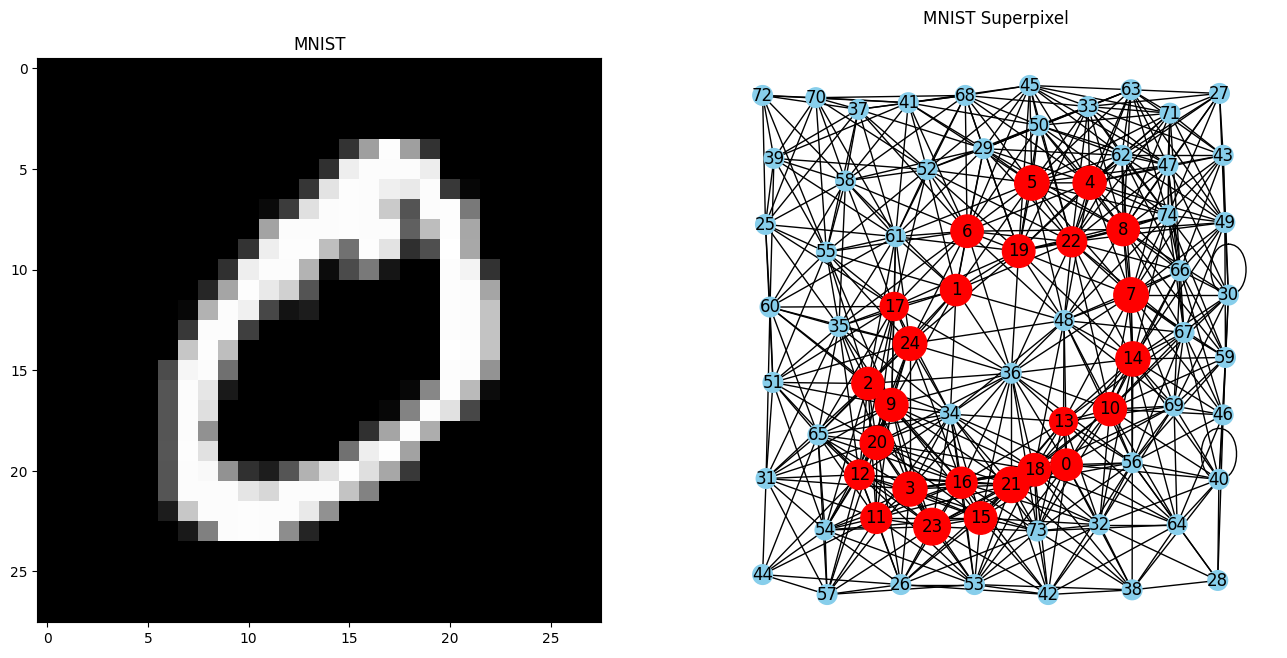

In [4]:
plt.figure(figsize=[16,8])
plt.subplot(1,2,1)
plt.title('MNIST')
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
x, edge_index = data.x, data.edge_index
print('x.shape', x.shape)
print('edge_index.shape', edge_index.shape)
print('pos.shape', data.pos.shape)
#print('x', x)
#print('edge_index', edge_index)
#print('pos', data.pos)
df = pd.DataFrame({'from': edge_index[0], 'to': edge_index[1]})
graph = nx.from_pandas_edgelist(df, 'from', 'to')

pos = {i: np.array([data.pos[i][0], 27-data.pos[i][1]]) for i in range(data.num_nodes)}
#pos = {i: np.array([data.pos[i][0], data.pos[i][1]]) for i in range(data.num_nodes)}
index = list(graph.nodes())
size = x[index]*500+200
color = []
for i in index:
    greyscale = x[i]
    if greyscale == 0:
        color.append('skyblue')
    else:
        color.append('red')

#print(len(pos))
#print(len(color))

nx.draw(graph, with_labels=True, node_size=size, node_color=color, pos=pos)
plt.title('MNIST Superpixel')

## Step1. Lightning data module for MNISTSuperpixels dataset ##

In [5]:
import os
import torch

from torch.utils.data import random_split
from pytorch_lightning import LightningDataModule
#from torch_geometric.data.lightning import LightningDataset
from torch_geometric.transforms import Cartesian
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.loader import DataLoader
from typing import Optional


class MNISTSuperpixelsDataset(LightningDataModule):
    def __init__(
        self,
        data_path: str,
        batch_size: int = 64
        ):
        super().__init__()
        self.data_dir = data_path
        self.transform = Cartesian(cat=False)
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit' or stage is None:
            full_data = MNISTSuperpixels(self.data_dir, train=True, transform=self.transform)
            #self.train_data = full_data[:50000]
            #self.val_data = full_data[50000:]
            self.train_data, self.val_data = random_split(full_data, [50000, 10000])
        if stage == 'test' or stage is None:
            self.test_data  = MNISTSuperpixels(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

In [6]:
#from torch_geometric.data.lightning import LightningDataset
#a=MNISTSuperpixelsDataset(data_path='/vols/solid/shingo/data', batch_size=64)
#a.setup()
#data = LightningDataset(a.train_data, a.val_data, a.test_data, batch_size=64, num_workers=4)

## Step2. GCN model ##

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.utils import normalized_cut
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    NNConv,
    graclus,
    global_mean_pool,
    max_pool,
    max_pool_x,
)


class GCN_NNConv(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.num_classes = num_classes

        self.transform = Cartesian(cat=False)

        nn1 = nn.Sequential(nn.Linear(2, 25), nn.ReLU(),
                            nn.Linear(25, self.num_features * 32))
        self.conv1 = NNConv(self.num_features, 32, nn1, aggr='mean')

        nn2 = nn.Sequential(nn.Linear(2, 25), nn.ReLU(),
                            nn.Linear(25, 32 * 64))
        self.conv2 = NNConv(32, 64, nn2, aggr='mean')

        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, self.num_classes)

    def forward(self, data):
        #print('forward nnconv')
        #print('data.edge_index', data.edge_index)
        #print('data.pos', data.pos)
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        weight = self.normalized_cut_2d(data.edge_index, data.pos)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data, transform=self.transform)

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        weight = self.normalized_cut_2d(data.edge_index, data.pos)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_mean_pool(x, batch)
        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return F.log_softmax(self.fc2(x), dim=1)

    def normalized_cut_2d(self, edge_index, pos):
        row, col = edge_index
        edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
        return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

## Step3. Pytorch lightning module ##

In [8]:
from typing import Any
from pytorch_lightning.utilities.types import STEP_OUTPUT
from torch import optim
from torch import Tensor
from torchmetrics.classification import Accuracy
#from torchmetrics import Accuracy
from pytorch_lightning import LightningModule
import torchmetrics



class GCN(LightningModule):
    def __init__(self, model, lr_rate):
        super(GCN, self).__init__()
        self.model = model
        self.lr_rate = lr_rate

        #self.save_hyperparameters()
        self.automatic_optimization = False
        self.accuracy_calc = Accuracy(task='multiclass', num_classes=10, top_k=1)

        self.training_step_loss = []
        self.validation_step_loss = []
        self.training_epoch_loss = []
        self.validation_epoch_loss = []

        self.training_step_acc = []
        self.validation_step_acc = []
        self.training_epoch_acc = []
        self.validation_epoch_acc = []        

    def forward(self, data):
        #print('forward gcn')
        return self.model(data)
    
    def cross_entropy_loss(self, x, y):
        return F.nll_loss(x, y)
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters())
        return opt

    def training_step(self, batch, batch_size):
    #def training_step(self, batch):
        opt = self.optimizers()
        opt.zero_grad()

        pred = self(batch)
        loss = self.cross_entropy_loss(pred, batch.y)
        acc = self.accuracy_calc(pred, batch.y)
        self.manual_backward(loss)
        opt.step()

        self.log('loss training', loss, prog_bar=True, on_step=True)
        self.training_step_loss.append(loss)
        self.training_step_acc.append(acc)

        return loss
    

    def validation_step(self, batch, batch_size) -> None:
    #def validation_step(self, batch) -> None:
        #print('valdation_step')
        pred = self(batch)
        loss = self.cross_entropy_loss(pred, batch.y)
        acc = self.accuracy_calc(pred, batch.y)

        self.log('loss validation', loss, prog_bar=True, on_step=True)
        self.validation_step_loss.append(loss)
        self.validation_step_acc.append(acc)

        return loss

    def on_train_epoch_end(self) -> None:
        if self.current_epoch == 0:
            self.training_epoch_loss.append(torch.Tensor([1.e1])[0])
            self.training_epoch_acc.append(torch.Tensor([0.5])[0])

        loss_mean = torch.stack(self.training_step_loss).mean()
        self.training_step_loss.clear()
        self.log('training_epoch_loss', loss_mean, prog_bar=True, on_epoch=True)
        self.training_epoch_loss.append(loss_mean)

        acc_mean = torch.stack(self.training_step_acc).mean()
        self.training_step_acc.clear()
        self.log('training_epoch_acc', acc_mean, prog_bar=True, on_epoch=True)
        self.training_epoch_acc.append(acc_mean)

    def on_validation_epoch_end(self) -> None:
        loss_mean = torch.stack(self.validation_step_loss).mean()
        self.validation_step_loss.clear()
        self.log('validation_epoch_loss', loss_mean, prog_bar=True, on_epoch=True)
        self.validation_epoch_loss.append(loss_mean)

        acc_mean = torch.stack(self.validation_step_acc).mean()
        self.validation_step_acc.clear()
        self.log('validation_epoch_acc', acc_mean, prog_bar=True, on_epoch=True)
        self.validation_epoch_acc.append(acc_mean)
    

## Step4. Log ##

In [9]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='./tb_logs/', name = 'NNConv')

## Step5. Build & fit model ##

In [10]:
data = MNISTSuperpixelsDataset(data_path='/vols/solid/shingo/data', batch_size=128)
#print(data.num_features, data.num_classes)
model_core = GCN_NNConv(num_features=1, num_classes=10)
model = GCN(model=model_core, lr_rate=0.01)


In [11]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import pytorch_lightning as pl

runner = Trainer(max_epochs=10,
                 accelerator='gpu',  # 'cpu', or 'gpu', 'auto'
                 logger=logger, 
                 callbacks=[TQDMProgressBar(refresh_rate=10)])

runner.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./tb_logs/NNConv
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | GCN_NNConv         | 66.0 K
1 | accuracy_calc | MulticlassAccuracy | 0     
-----------------------------------------------------
66.0 K    Trainable params
0         Non-trainable params
66.0 K    Total params
0.264     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/hep/shayashi/.pyenv/versions/3.8.16/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/hep/shayashi/.pyenv/versions/3.8.16/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9600. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/hep/shayashi/.pyenv/versions/3.8.16/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s, v_num=0, loss training=1.750, loss validation_step=1.710, loss validation_epoch=1.790, validation_epoch_loss=1.790, validation_epoch_acc=0.350]          

/home/hep/shayashi/.pyenv/versions/3.8.16/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1200. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 9: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s, v_num=0, loss training=0.975, loss validation_step=0.663, loss validation_epoch=1.070, validation_epoch_loss=1.070, validation_epoch_acc=0.634, training_epoch_loss=1.180, training_epoch_acc=0.589]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s, v_num=0, loss training=0.975, loss validation_step=0.663, loss validation_epoch=1.070, validation_epoch_loss=1.070, validation_epoch_acc=0.634, training_epoch_loss=1.180, training_epoch_acc=0.589]


## Step6. Loss & Accuracy ##

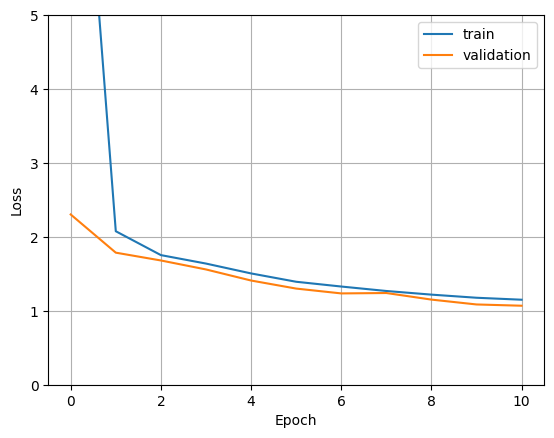

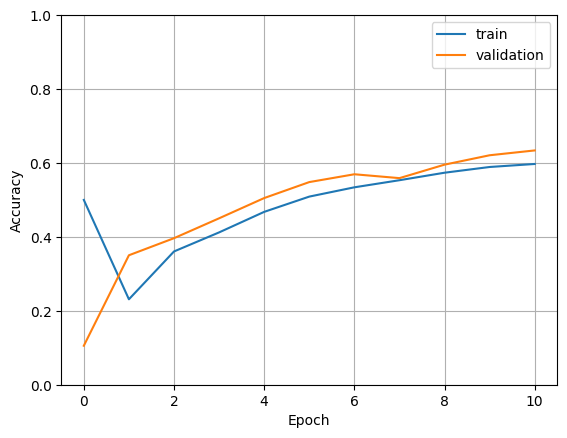

In [12]:
import matplotlib.pyplot as plt

train_loss = [i.to('cpu').detach().numpy() for i in model.training_epoch_loss]
train_acc = [i.to('cpu').detach().numpy() for i in model.training_epoch_acc]
val_loss = [i.to('cpu').detach().numpy() for i in model.validation_epoch_loss]
val_acc = [i.to('cpu').detach().numpy() for i in model.validation_epoch_acc]


plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.ylim(0,5)
plt.legend()
plt.show()


plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()
